# Initializing Libraries, Functions and data folder

In [17]:
import uproot
import awkward as ak
import numpy as np
import math
import hist
import matplotlib.pyplot as plt
import os
import subprocess
import vector
import gc
from matplotlib.colors import LogNorm

from Plot import Plot

ModuleNotFoundError: No module named 'Plot'

In [2]:
vector.register_awkward() 

In [3]:
DATATYPE="data"
assert((DATATYPE=="mc") or (DATATYPE=="data"))
BASEDIR="/pbs/throng/training/nantes-m2-rps-exp/data" # basedir where to look for runXXX.DATATYPE.root files
IS_MC=True if DATATYPE=="mc" else False

In [4]:
def data_file_path(run,is_mc=IS_MC,dest=BASEDIR):
    datatype="mc" if is_mc else "data"
    print({dest},"/run",{run},".",{datatype},".root")
    return f"{dest}/run{run}.{datatype}.root"

## Functions definitions and run choices

In [5]:
SAMPLE_RUNS=[291694, ]

In [6]:
file = uproot.open(data_file_path(SAMPLE_RUNS[0],IS_MC))

{'/pbs/throng/training/nantes-m2-rps-exp/data'} /run {291694} . {'data'} .root


In [7]:
def getTracks(events):
    return ak.zip({"px":events["Muon_Px"],
                       "py":events["Muon_Py"],
                       "pz":events["Muon_Pz"],
                       "E":events["Muon_E"],
                       "DCAx":events["Muon_xDCA"],
                       "DCAy":events["Muon_yDCA"],
                       "DCAz":events["Muon_zDCA"],
                       "charge":events["Muon_Charge"],
                       "thetaAbs":events["Muon_thetaAbs"],
                       "matched":events["Muon_matchedTrgThreshold"],
                       "isCMUL":events["isCMUL"]},
                    with_name='Momentum4D')

In [8]:
def scan(dataDescription, 
              hMag:hist.Hist, hPhi:hist.Hist, hPT:hist.Hist, hpDCA:hist.Hist, hsigmapDCA:hist.Hist, hfraction:hist.Hist, hcharge:hist.Hist, hP:hist.Hist, hpDCA_VS_p:hist.Hist,
              eventSelector=lambda x:[True]*len(x),
              trackSelector=lambda x:[True]*len(x), 
              verbose:bool=False):
    """ Loop over data to fill the invariant mass histogram.
        
        :param: dataDescription: is anything uproot.iterate can take.
                typical something like run*.data.root:eventsTree in our case
        :param: eventSelector: returns an array of bool from an array of events
        :param: trackSelector: returns an array of bool from an array of tracks
    """
    
    for batch in uproot.iterate(dataDescription,
                                ["isCINT","isCMUL","isCMSL","Muon_Px","Muon_Py","Muon_Pz","Muon_E","Muon_xDCA","Muon_yDCA","Muon_zDCA","Muon_Charge","Muon_thetaAbs","Muon_matchedTrgThreshold"],                                
                                 report=True):
        events=batch[0] # batch[1] is the report info
        if len(events) < 1000:
            print("something is wrong",batch[1]) # this is a protection for some corrupted input data files 
            break
            
        goodEvents = events[eventSelector(events)] 
        
        tracks = getTracks(goodEvents)
        goodTracks=tracks[trackSelector(tracks)]

        DCA=np.sqrt(goodTracks.DCAx**2 + goodTracks.DCAy**2 + goodTracks.DCAz**2)
        p0=ak.where(goodTracks.thetaAbs < 3 , goodTracks.p - 3.0, goodTracks.p - 2.4)
        pDCA=p0*DCA

        N=1 #choice of resolution should be a number between 1 and 10
        sigmaAbs=ak.where(goodTracks.thetaAbs < 3, 80.0, 54.0) #factor used due to the crossed materials 
        pRes= 0.0004 * goodTracks.p
        sigmap= sigmaAbs/ (1 - ((N*pRes)/(1 + N*pRes)))

        thetaRes= 0.0005 * goodTracks.p
        sigmatheta= 535 * thetaRes

        #computing total resolution for pDCA
        sigmapDCA=np.sqrt(sigmap**2 + sigmatheta**2)

        ##function to choose the N value
        fraction=pDCA/sigmapDCA
    
        hMag.fill(ak.flatten(goodTracks.p))
        hPhi.fill(ak.flatten(goodTracks.phi))  
        hPT.fill(ak.flatten(goodTracks.pt))
        hpDCA.fill(ak.flatten(pDCA))
        hsigmapDCA.fill(ak.flatten(sigmapDCA))
        hfraction.fill(ak.flatten(fraction))
        hcharge.fill(ak.flatten(goodTracks.charge))
        hP.fill(ak.flatten(goodTracks.p))
        hpDCA_VS_p.fill(
            p=ak.flatten(goodTracks.p),
            pDCA=ak.flatten(pDCA))

        
        if verbose:
            print(batch[1])
        gc.collect()


## Filling histograms

In [9]:
%%time
#No cuts
vhMagRaw = hist.Hist(hist.axis.Regular(bins=100,start=0,stop=100,name='$|p|$'))
vhPhiRaw = hist.Hist(hist.axis.Regular(bins=200,start=-22/7,stop=22/7,name=r'$\phi$'))
vhPTRaw = hist.Hist(hist.axis.Regular(bins=1000,start=0,stop=100,name='$p_T$'))
vhpDCARaw = hist.Hist(hist.axis.Regular(bins=200,start=0,stop=2500,name='pDCA'))
vhsigmapDCARaw = hist.Hist(hist.axis.Regular(bins=200,start=0,stop=300,name=r'$\sigma_{pDCA}$'))
vhfractionRaw = hist.Hist(hist.axis.Regular(bins=200,start=0,stop=10,name=r'pDCA/$\sigma_{pDCA}$'))
vhchargeRaw = hist.Hist(hist.axis.Regular(bins=200,start=-100,stop=100,name='Charge'))
vhPRaw = hist.Hist(hist.axis.Regular(bins=1000,start=0,stop=100,name='p'))
vhpDCA_VS_pRaw = hist.Hist(
    hist.axis.Regular(bins=1000, start=0, stop=50, name="p", label=r"$p$"),
    hist.axis.Regular(bins=1000, start=0, stop=500, name="pDCA", label=r"pDCA")
)


#Event selection
vhMagEvSel = hist.Hist(hist.axis.Regular(bins=100,start=0,stop=100,name='$|p|$'))
vhPhiEvSel = hist.Hist(hist.axis.Regular(bins=200,start=-22/7,stop=22/7,name=r'$\phi$'))
vhPTEvSel = hist.Hist(hist.axis.Regular(bins=1000,start=0,stop=100,name='$p_T$'))
vhpDCAEvSel = hist.Hist(hist.axis.Regular(bins=200,start=0,stop=2500,name='pDCA'))
vhsigmapDCAEvSel = hist.Hist(hist.axis.Regular(bins=200,start=0,stop=300,name=r'$\sigma_{pDCA}$'))
vhfractionEvSel = hist.Hist(hist.axis.Regular(bins=200,start=0,stop=10,name=r'pDCA/$\sigma_{pDCA}$'))
vhchargeEvSel = hist.Hist(hist.axis.Regular(bins=200,start=-100,stop=100,name='Charge'))
vhPEvSel = hist.Hist(hist.axis.Regular(bins=1000,start=0,stop=100,name='p'))
vhpDCA_VS_pEvSel = hist.Hist(
    hist.axis.Regular(bins=1000, start=0, stop=50, name="p", label=r"$p$"),
    hist.axis.Regular(bins=1000, start=0, stop=500, name="pDCA", label=r"pDCA")
)

scan(dataDescription=f"{BASEDIR}/run291694.{DATATYPE}.root:eventsTree",
          hMag=vhMagRaw, hPhi=vhPhiRaw, hPT=vhPTRaw, hpDCA=vhpDCARaw, hsigmapDCA=vhsigmapDCARaw, hfraction=vhfractionRaw, hcharge = vhchargeRaw, hP=vhPRaw, hpDCA_VS_p=vhpDCA_VS_pRaw)

scan(dataDescription=f"{BASEDIR}/run291694.{DATATYPE}.root:eventsTree",
          hMag=vhMagEvSel, hPhi=vhPhiEvSel, hPT=vhPTEvSel, hpDCA=vhpDCAEvSel, hsigmapDCA=vhsigmapDCAEvSel, hfraction=vhfractionEvSel, hcharge =vhchargeEvSel, hP=vhPEvSel, hpDCA_VS_p=vhpDCA_VS_pEvSel,
          #eventSelector=lambda x: x["isCMSL"]==True,
          trackSelector=lambda x: (x.pt>0.5))
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Please write the cuts made ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
EventsCut= "No cuts"
TracksCut = r"p$_T$>0.5"

CPU times: user 11.2 s, sys: 1.7 s, total: 12.9 s
Wall time: 13 s


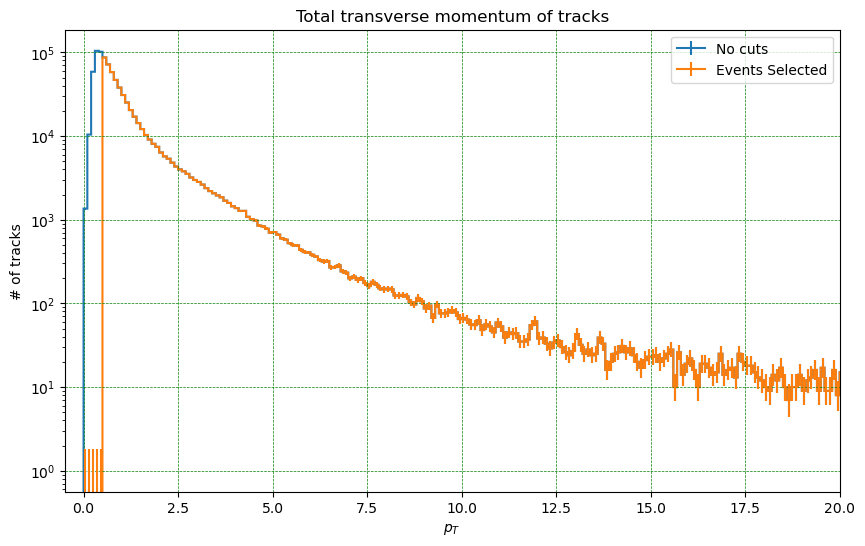

In [10]:
plt.figure(figsize=(10, 6))
#vhMagRaw.plot(label="no cuts")
#vhMagEvSel.plot(label="events selected")
#R.plot(label=r"p$_T^{Trig}$/p$_T$")
vhPTRaw.plot(label="No cuts")
vhPTEvSel.plot(label="Events Selected")
plt.yscale("log")
plt.xlim(-0.5,20)
plt.ylabel("# of tracks")
plt.title('Total transverse momentum of tracks');
plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)
plt.legend();

## pDCA

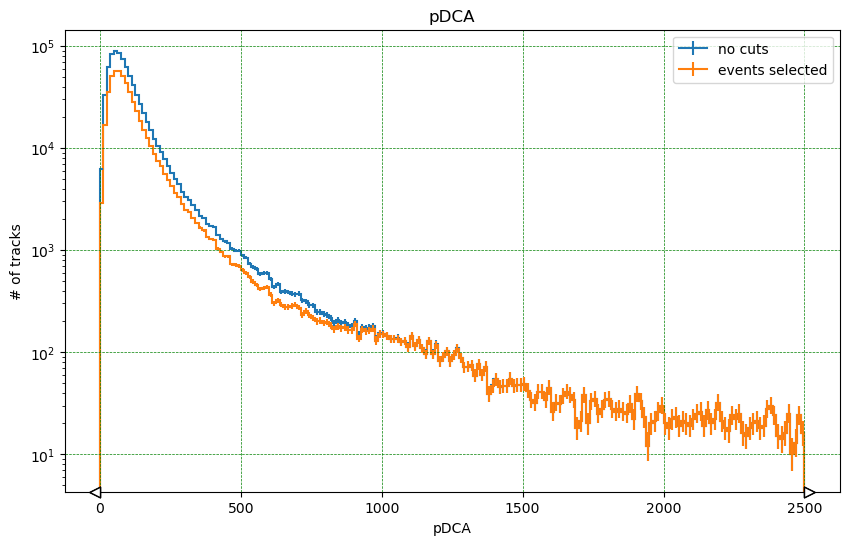

In [11]:
plt.figure(figsize=(10, 6))
vhpDCARaw.plot(label="no cuts")
vhpDCAEvSel.plot(label="events selected")
plt.yscale("log")
plt.ylabel("# of tracks")
plt.title('pDCA');
plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)
plt.legend();
#plt.savefig("pDCA_run291694.png")

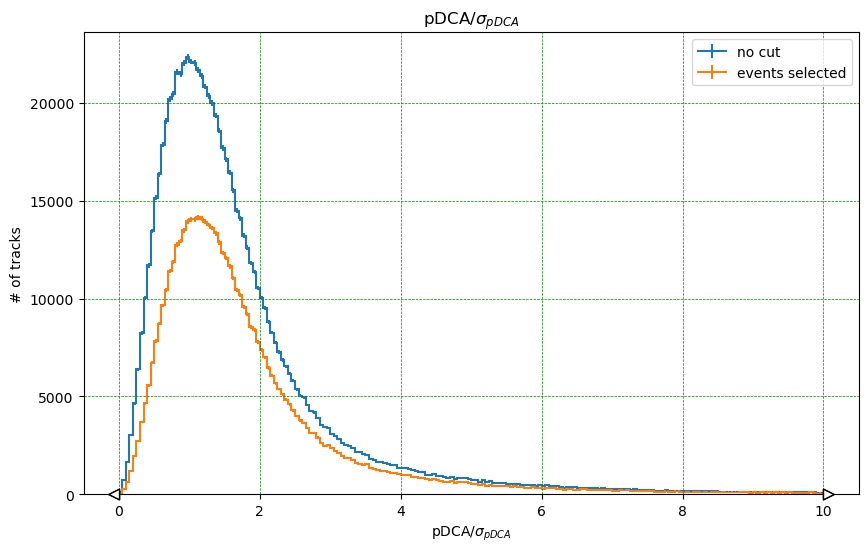

In [12]:
plt.figure(figsize=(10, 6))
vhfractionRaw.plot(label="no cut")
vhfractionEvSel.plot(label="events selected")
plt.ylabel("# of tracks")
plt.title(r'pDCA/$\sigma_{pDCA}$');
plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)
plt.legend();
#plt.savefig("pDCA_sigmapDCA_run291694.png")

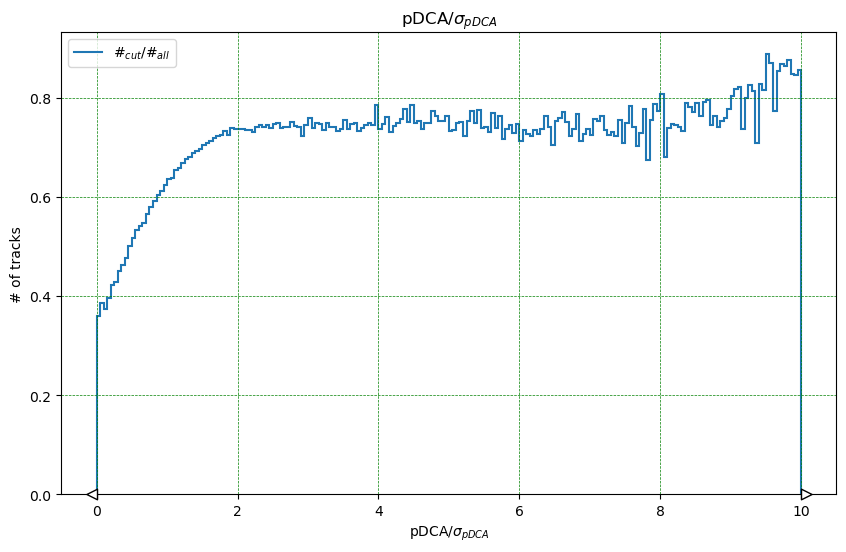

In [13]:
plt.figure(figsize=(10, 6))
R = vhfractionEvSel/vhfractionRaw
R.plot(label=r'#$_{cut}$/#$_{all}$')
#plt.yscale("log")
plt.ylabel("# of tracks")
plt.title(r'pDCA/$\sigma_{pDCA}$');
plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)
plt.legend();
#plt.savefig("pDCA_sigmapDCA_run291694.png")

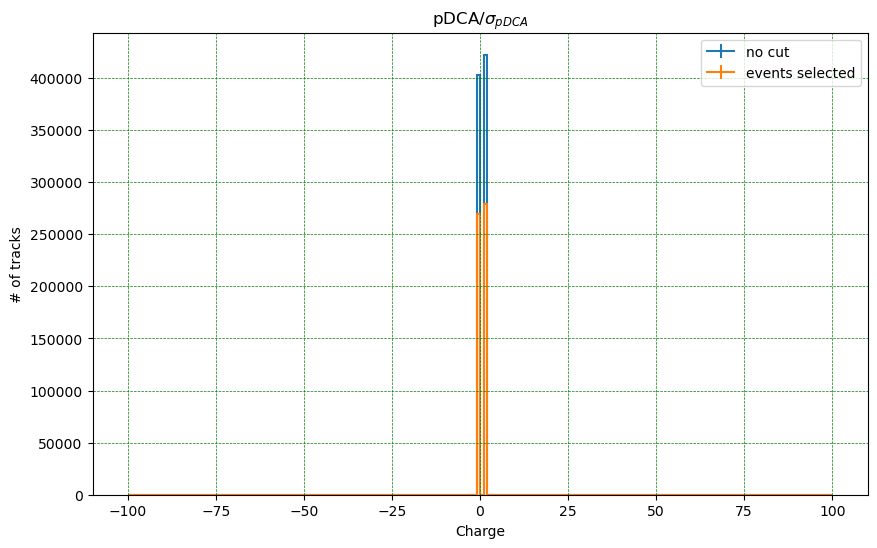

In [14]:
plt.figure(figsize=(10, 6))
vhchargeRaw.plot(label="no cut")
vhchargeEvSel.plot(label="events selected")
plt.ylabel("# of tracks")
plt.title(r'pDCA/$\sigma_{pDCA}$');
plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)
plt.legend();
#plt.savefig("pDCA_sigmapDCA_run291694.png")

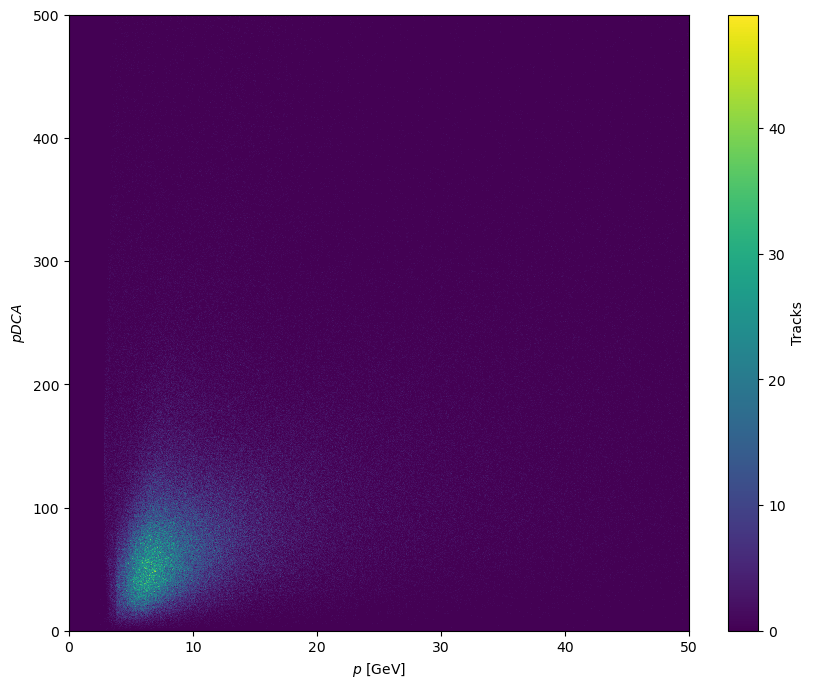

In [15]:
plt.figure(figsize=(10, 8))
plt.pcolormesh(*vhpDCA_VS_pRaw.axes.edges.T, vhpDCA_VS_pRaw.values().T, cmap='viridis')
plt.colorbar(label='Tracks')
plt.xlabel(r'$p$ [GeV]')
plt.ylabel(r'$pDCA$')
plt.show()

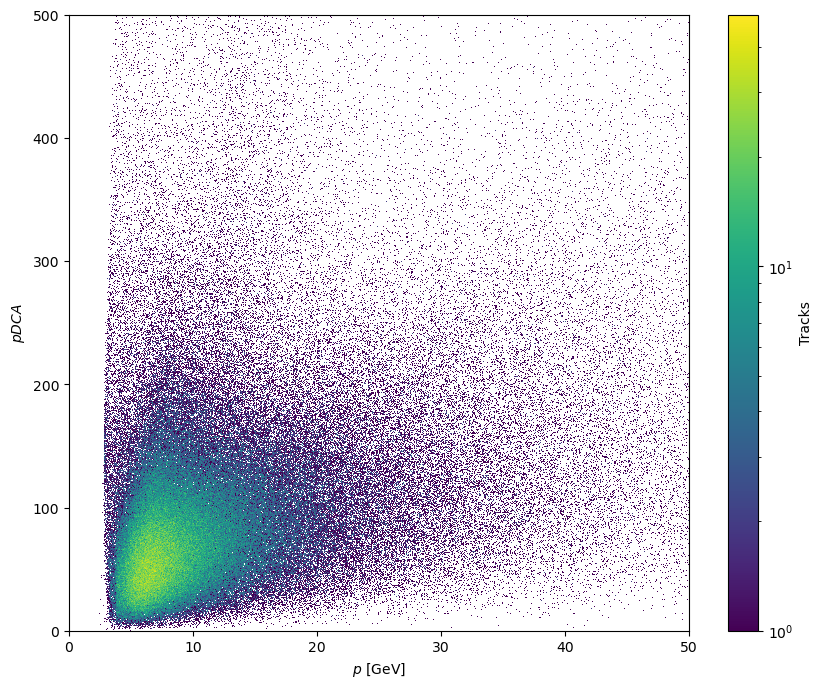

In [21]:
plt.figure(figsize=(10, 8))
plt.pcolormesh(*vhpDCA_VS_pRaw.axes.edges.T, np.ma.masked_less_equal(vhpDCA_VS_pRaw.values().T,0), cmap='viridis', norm=LogNorm())
plt.colorbar(label='Tracks')
plt.xlabel(r'$p$ [GeV]')
plt.ylabel(r'$pDCA$')
plt.show()

## Testing Plot function

In [16]:
Plot(vhfractionRaw, vhfractionEvSel, "No cuts",  "Event Cuts : "+ EventsCut + " ; Track Cuts : " + TracksCut, r"pDCA/$\sigma_{pDCA}$")

NameError: name 'Plot' is not defined

In [ ]:
Plot(vhfractionRaw, labelH1="No cuts", labelx=r"pDCA/$\sigma_{pDCA}$")

In [ ]:
Plot(vhfractionRaw, vhfractionEvSel, "No cuts",  "Event Cuts : "+ EventsCut + " ; Track Cuts : " + TracksCut, r"pDCA/$\sigma_{pDCA}$", ratio =True, save=True)

## Then we can check if isCMUL boolean is correct

In [ ]:
for m in events.iterate(["nMuons","Muon_Px","Muon_Py","Muon_Pz","Muon_Charge"],how="zip",step_size=10000):
    for charge in m["Muon_Charge"]:
        if (-1 in charge) and (1 in charge) :
            GoodEvent += 1
vhisCMULRaw.sum() 

print("Real Events with opposite charges di-muon is : " + GoodEvent)
print("Real Events with opposite charges di-muon is : " + GoodEvent)